# Teste da velocidade no uso de paralelismo no programa

In [1]:
from file import fits
from stats import z2n
import numpy as np

from multiprocessing import Pool

import matplotlib.pyplot as plt

import objgraph
x = [1]
objgraph.show_backrefs([x], filename='backref.png')

plt.style.use('ggplot')
%matplotlib inline
%load_ext line_profiler
%load_ext memory_profiler

## Carregando o arquivo FITS na memória

In [2]:
time = fits.load_fits('../rxj_pnevtlist_0310kev_baryc.ds.gz')
time

array([1.90508838e+08, 1.90508838e+08, 1.90508839e+08, ...,
       1.90548859e+08, 1.90548862e+08, 1.90548865e+08])

## Definindo limites e o delta do espectro de potências

In [3]:
freq = np.arange(1e-4, 1.5e-3, 1e-6)
freq

array([0.0001  , 0.000101, 0.000102, ..., 0.001497, 0.001498, 0.001499])

## Achando o período sem paralelismo

In [4]:
sem = %timeit -o z2n.period(time)

952 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Achando o período com paralelismo

In [5]:
parallel = Pool(4)
com = %timeit -o parallel.map(z2n.period, time)

581 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Vendo a diferença graficamente

<BarContainer object of 2 artists>

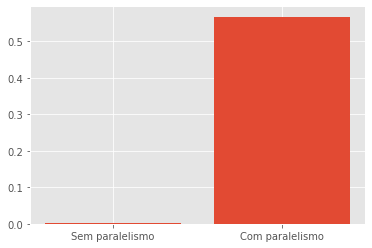

In [6]:
labels = ["Sem paralelismo", "Com paralelismo"]
values = [sem.best, com.best]
plt.bar(labels, values)

## Analisando vazamentos de memoria

In [7]:
%prun z2n.periodogram(time, freq)

Calculating Z2n Statistics: 100%|██████████| 1400/1400 [00:01<00:00, 949.19it/s]

         81312 function calls (81310 primitive calls) in 4.950 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.247    3.247    3.304    3.304 z2n.py:65(phases)
        1    1.448    1.448    4.925    4.925 z2n.py:107(periodogram)
     2800    0.107    0.000    0.107    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    35114    0.041    0.000    0.073    0.000 std.py:1067(__iter__)
        1    0.025    0.025    4.950    4.950 <string>:1(<module>)
      230    0.021    0.000    0.021    0.000 {method 'acquire' of '_thread.lock' objects}
     2800    0.012    0.000    0.122    0.000 fromnumeric.py:73(_wrapreduction)
     2800    0.011    0.000    0.136    0.000 fromnumeric.py:2045(sum)
     2800    0.006    0.000    0.148    0.000 <__array_function__ internals>:2(sum)
2803/2801    0.005    0.000    0.141    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      102    0.005    0.

In [8]:
%lprun -f z2n.periodogram z2n.periodogram(time, freq)

Calculating Z2n Statistics: 100%|██████████| 1400/1400 [00:01<00:00, 737.19it/s]


Timer unit: 1e-06 s

Total time: 6.97262 s
File: /home/yohan/Github/z2n-periodogram/stats/z2n.py
Function: periodogram at line 107

Line #      Hits         Time  Per Hit   % Time  Line Contents
   107                                           def periodogram(arrival_times: np.array, frequencies: np.array) -> np.array:
   108                                               """
   109                                               Applies the Z2n statistics to phase values and normalize.
   110                                           
   111                                               Parameters
   112                                               ----------
   113                                               arrival_times : numpy.array
   114                                                   Numpy array that represents the photon arrival times.
   115                                               frequencies : numpy.array
   116                                                   Numpy

In [9]:
%memit z2n.periodogram(time, freq)

Calculating Z2n Statistics: 100%|██████████| 1400/1400 [00:01<00:00, 761.07it/s]


peak memory: 1182.14 MiB, increment: 1067.89 MiB


In [10]:
%mprun -f z2n.periodogram z2n.periodogram(time, freq)

Calculating Z2n Statistics: 100%|██████████| 1400/1400 [00:02<00:00, 473.80it/s]


Filename: /home/yohan/Github/z2n-periodogram/stats/z2n.py

Line #    Mem usage    Increment   Line Contents
   107    113.9 MiB    113.9 MiB   def periodogram(arrival_times: np.array, frequencies: np.array) -> np.array:
   108                                 """
   109                                 Applies the Z2n statistics to phase values and normalize.
   110                             
   111                                 Parameters
   112                                 ----------
   113                                 arrival_times : numpy.array
   114                                     Numpy array that represents the photon arrival times.
   115                                 frequencies : numpy.array
   116                                     Numpy array that represents the frequency spectrum.
   117                             
   118                                 Returns
   119                                 -------
   120                                 potency : n